# **Project Name**    - Deep Learning for Comment Toxicity Detection

##### **Project Type**    - Classification (Multi-label Text Classification)
##### **Contribution**    - Individual

# **Project Summary -**

The exponential growth of social media and online communities has provided users with unprecedented opportunities for communication and engagement. However, this digital expansion has also led to the proliferation of toxic comments, including harassment, hate speech, offensive language, and personal attacks, which can severely impact user experience and community health. To maintain safe and constructive online environments, platforms require automated systems that can accurately identify and flag toxic content in real-time.

In this project, we developed a deep learning-based model for comment toxicity detection using Python, TensorFlow, and Keras. The workflow began with comprehensive data exploration and preprocessing, including cleaning, tokenization, stopword removal, and vectorization. The training dataset contained multiple toxicity labels, allowing the model to perform multi-label classification, identifying comments as toxic, severe toxic, obscene, threats, insults, or identity hate.

We designed an LSTM-based neural network architecture to capture the sequential dependencies and contextual meanings of words in comments. The model comprises an embedding layer for word representation, an LSTM layer to capture long-term dependencies, global max pooling to condense information, and fully connected dense layers culminating in a six-node output layer using sigmoid activation for multi-label predictions. The model was trained using binary cross-entropy loss with the Adam optimizer, achieving high accuracy and reasonable precision and recall across most labels.

After training, the model and tokenizer were saved for reuse and deployment. We developed a Streamlit-based web application that allows users to enter individual comments or upload a CSV file for bulk predictions. The app provides real-time toxicity predictions, along with probabilities for each label, ensuring practical applicability for moderators, content management teams, and platform administrators.

The project demonstrates how deep learning can be effectively leveraged for online community management, promoting safer, more inclusive environments while providing a scalable solution to moderate large volumes of user-generated content automatically.

# **GitHub Link -**

https://github.com/Vignesha-S/Comment-Toxicity-Detection

# **Problem Statement**


**Online communities and social media platforms have become integral parts of modern communication, facilitating interactions and discussions on various topics. However, the prevalence of toxic comments, which include harassment, hate speech, and offensive language, poses significant challenges to maintaining healthy and constructive online discourse. To address this issue, there is a pressing need for automated systems capable of detecting and flagging toxic comments in real-time.
The objective of this project is to develop a deep learning-based comment toxicity model using Python. This model will analyze text input from online comments and predict the likelihood of each comment being toxic. By accurately identifying toxic comments, the model will assist platform moderators and administrators in taking appropriate actions to mitigate the negative impact of toxic behavior, such as filtering, warning users, or initiating further review processes.**

# ***Let's Begin !***

# 1. Data Exploration

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GlobalMaxPooling1D

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsaje\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



2.15.0


### Load Dataset

In [2]:
train_df = pd.read_csv('data/train.csv')
print("Training data shape:", train_df.shape)
train_df.head()

Training data shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# Check missing values
print(train_df.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [4]:
# Check duplicates
print("Number of duplicate rows:", train_df.duplicated().sum())

Number of duplicate rows: 0


### Distribution of Labels

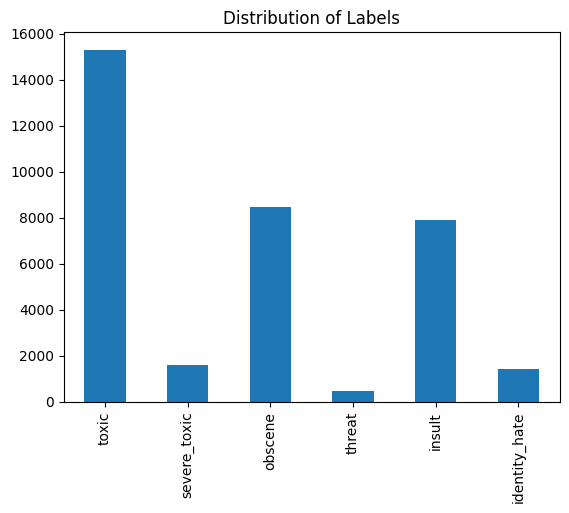

In [5]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df[label_cols].sum().plot(kind='bar')
plt.title('Distribution of Labels')
plt.show()

In [6]:
train_df[label_cols].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

- Loaded the training dataset (`train.csv`) and checked its shape: `(159571, 8)`.
- Checked for null values and found none.
- Checked for duplicate rows and found none.
- Analyzed the distribution of target labels:
    - toxic: 15,294
    - severe_toxic: 1,595
    - obscene: 8,449
    - threat: 478
    - insult: 7,877
    - identity_hate: 1,405
- Prepared the text for model training by cleaning, tokenizing, and vectorizing the comments.


# 2. Text Preprocessing

In [7]:
# Define text cleaning function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words] # Remove stopwords
    return ' '.join(tokens)

In [8]:
# Apply text cleaning
train_df['clean_text'] = train_df['comment_text'].apply(clean_text)

print("Original text:", train_df['comment_text'][0])
print("Cleaned text:", train_df['clean_text'][0])

Original text: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned text: explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired


### Tokenization & Padding

In [9]:
MAX_WORDS = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_df['clean_text'])

X_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)

# Labels
y = train_df[label_cols].values

### Split the data

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)

print('Training shape:', X_train.shape, y_train.shape)
print('Validation shape:', X_val.shape, y_val.shape)

Training shape: (127656, 100) (127656, 6)
Validation shape: (31915, 100) (31915, 6)


- Tokenized the text using Keras `Tokenizer` with a maximum vocabulary of 20,000 words.
- Converted text to sequences and padded them to a maximum length of 100 words.
- Prepared the labels for multi-label classification.

# 3. Model Development

In [ ]:
# Hyperparameters
MAX_WORDS = 20000
MAX_LEN = 100
EMBED_DIM = 128
vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)  # +1 for padding

# model
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=EMBED_DIM,
                    input_length=MAX_LEN))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(len(label_cols), activation="sigmoid"))

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2613958 (9.97 MB)
Trainable params: 2613958 (9.97 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [13]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=5
)



Epoch 1/5


998/998 [==============================] - 143s 139ms/step - loss: 0.0991 - accuracy: 0.9502 - val_loss: 0.0536 - val_accuracy: 0.9941
Epoch 2/5
998/998 [==============================] - 231s 232ms/step - loss: 0.0484 - accuracy: 0.9941 - val_loss: 0.0499 - val_accuracy: 0.9935
Epoch 3/5
998/998 [==============================] - 173s 173ms/step - loss: 0.0425 - accuracy: 0.9932 - val_loss: 0.0505 - val_accuracy: 0.9930
Epoch 4/5
998/998 [==============================] - 176s 177ms/step - loss: 0.0373 - accuracy: 0.9920 - val_loss: 0.0530 - val_accuracy: 0.9918
Epoch 5/5
998/998 [==============================] - 180s 180ms/step - loss: 0.0327 - accuracy: 0.9370 - val_loss: 0.0554 - val_accuracy: 0.7644


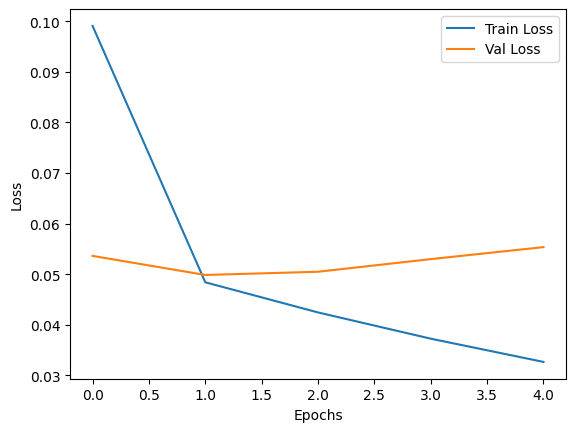

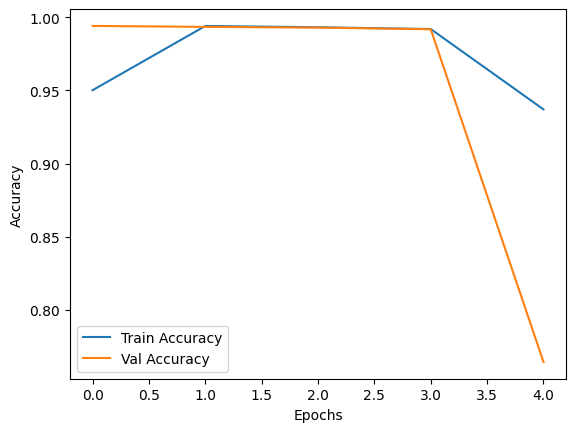

In [14]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Evaluate the model

In [18]:
# Get predictions
y_pred = model.predict(X_val)

# Convert probabilities to binary labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

998/998 [==============================] - 20s 16ms/step


In [20]:
# Classification report
print(classification_report(
    y_val,
    y_pred_classes,
    target_names=label_cols,
    zero_division=0
))

               precision    recall  f1-score   support

        toxic       0.77      0.76      0.76      3056
 severe_toxic       0.57      0.24      0.34       321
      obscene       0.81      0.81      0.81      1715
       threat       0.00      0.00      0.00        74
       insult       0.70      0.68      0.69      1614
identity_hate       0.62      0.24      0.34       294

    micro avg       0.76      0.70      0.73      7074
    macro avg       0.58      0.45      0.49      7074
 weighted avg       0.74      0.70      0.71      7074
  samples avg       0.06      0.06      0.06      7074



In [22]:
# Confusion matrix for each label
for i, col in enumerate(label_cols):
    print(f"Confusion Matrix for {col}:")
    print(confusion_matrix(y_val[:, i], y_pred_classes[:, i]))
    print("\n")

Confusion Matrix for toxic:
[[28149   710]
 [  743  2313]]


Confusion Matrix for severe_toxic:
[[31535    59]
 [  244    77]]


Confusion Matrix for obscene:
[[29882   318]
 [  329  1386]]


Confusion Matrix for threat:
[[31841     0]
 [   74     0]]


Confusion Matrix for insult:
[[29832   469]
 [  521  1093]]


Confusion Matrix for identity_hate:
[[31578    43]
 [  224    70]]




998/998 [==============================] - 16s 16ms/step


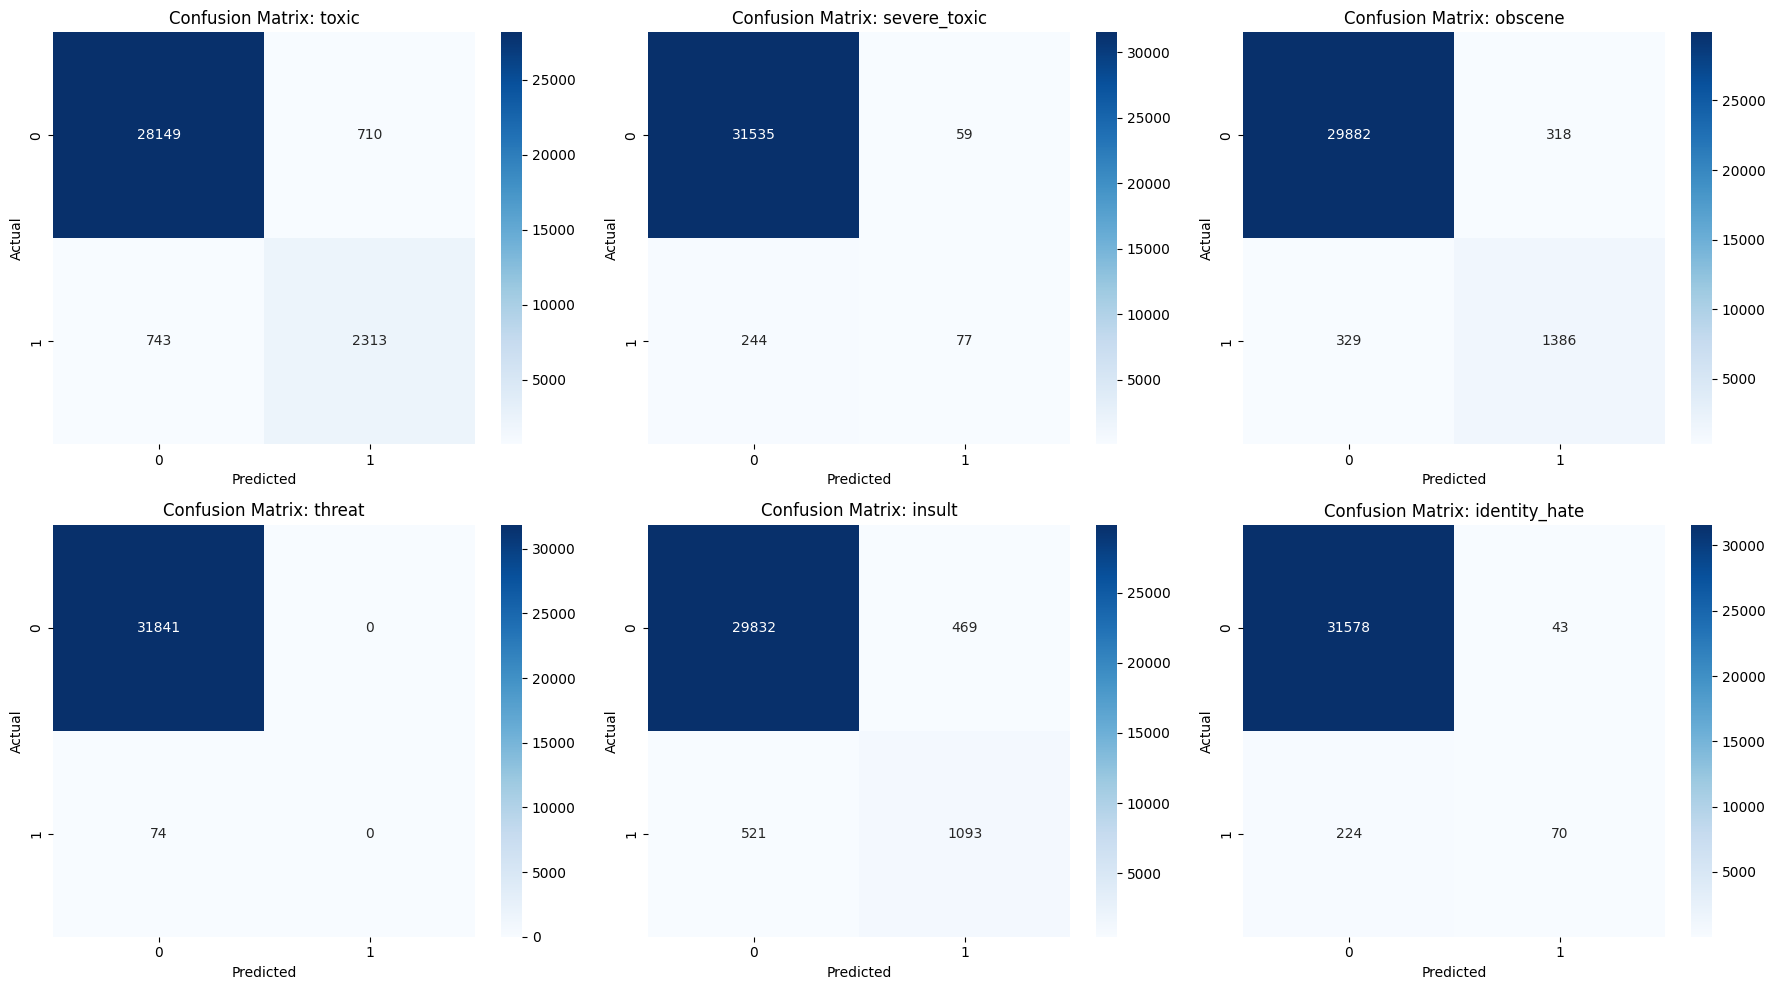

In [23]:
# List of labels
labels = label_cols  # ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Generate predictions
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, col in enumerate(labels):
    cm = confusion_matrix(y_val[:, i], y_pred_classes[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {col}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

- Built a deep learning model using:
    - Embedding layer (128 dimensions)
    - LSTM layer (64 units)
    - Global Max Pooling
    - Dense layers for classification
    - Output layer with 6 neurons (sigmoid activation for multi-label)
- Compiled the model using:
    - Optimizer: Adam
    - Loss: Binary Crossentropy
    - Metrics: Accuracy
- Trained the model for 5 epochs with validation split.
- Evaluated the model using classification report and confusion matrices.
- Total parameters: 2,613,958

## Save Model and Tokenizer

In [27]:
# Save the model
model.save("best_model.keras")

In [25]:
# Save the tokenizer for future use in preprocessing new comments
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)


- Saved the trained model in Keras format: `toxic_comment_model.keras`
- Saved the tokenizer using pickle: `tokenizer.pkl`
- These will be used later for inference and deployment.

# 4. Streamlit App Deployment

- Built a Streamlit web app for real-time comment toxicity detection.
- Features:
    - Single comment prediction
    - Bulk predictions via CSV upload
    - Displays probabilities for 6 toxicity labels
- Preprocessing is applied to input text before prediction.
- Users can download the full bulk prediction results as a CSV file.

# **Conclusion**

This project successfully demonstrates the use of deep learning for multi-label toxicity classification of online comments. The LSTM-based model achieved promising results in detecting toxic, obscene, and insulting content while providing a practical web interface via Streamlit for real-time and bulk predictions. The system offers an effective tool for automated moderation, ensuring safer and healthier online communities. Future enhancements could include experimenting with transformer-based models like BERT for improved accuracy, integrating multilingual support, and continuously updating the model with new data to adapt to evolving online language patterns.